# Поиск токсичных комментариев

Интернет-магазин запускает сервис, в котором пользователи могут редактировать и дополнять описания товаров. Необходимо построить модель, которая который будет искать токсичные комментарии и отправлять их на модерацию. 
В распоряжении набор данных с разметкой о токсичности правок.
Значение метрики качества *F1* должно быть не меньше 0.75. 

Исследование будет проходить в несколько этапов:
- изучение данных, в том числе дисбаланса классов;
- подготовка текстов: удаление знаков препинания, лишних символов, лемматизация;
- выделение целевого и обучающих признаков;
- разделение датафрейма на обучающий и тестовый;
- обучение моделей Логистической регрессии, Дерева решений и градиентного бустинга LightGBM;
- выбор оптимальной модели на основании метрики f1;
- проверка выбранной модели на тестовой выборке

## 1 Подготовка

In [15]:
import pandas as pd
import numpy as np
import nltk
import re 

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

from nltk.corpus import stopwords 
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords') 
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer 
from nltk.stem import WordNetLemmatizer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm.notebook import tqdm

import seaborn as sns

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
data = pd.read_csv('/datasets/toxic_comments.csv')

### 1.1 Изучение данных

In [17]:
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [18]:
data.tail()

,Unnamed: 0,text,toxic
159287,159446,""":::::And for the second time of asking, when ...",0
159288,159447,You should be ashamed of yourself \n\nThat is ...,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,159449,And it looks like it was actually you who put ...,0
159291,159450,"""\nAnd ... I really don't think you understand...",0


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [20]:
data.duplicated().sum()

0

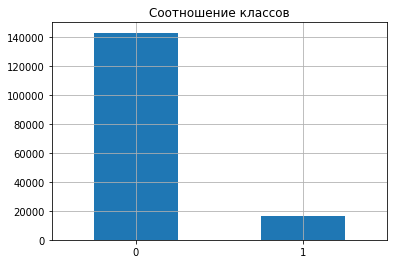

In [42]:
# рассмотрим соотношение классов
data['toxic'].value_counts().plot.bar(rot=0, grid=True, title ='Соотношение классов');


In [43]:
data.toxic.value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

Итак, датафрейм состоит из 159292 объектов, пропуски и явные дубликаты отсутствуют. Тексты написаны на английском языке, в них присутствуют знаки препинания, буквы разного регистра, лишние символы и пробелы. Имеется дисбаланс классов - положительных почти в 9 раз больше, чем отрицательных, необходимо будет учесть это при обучении моделей. 

### 1.2 Подготовка данных

Удалим из датафрейма столбец 'Unnamed: 0', поскольку он содержит нумерацию и не будет участвовать в создании признаков. 

In [44]:
data = data.drop('Unnamed: 0', axis=1)

Подготовим тексты для создания признаков: приведем к нижнему регистру, избавимся от знаков препинания, лишних пробелов, лемматизируем. Чтобы исходный датафрейм также сохранился, сделаем его копию.

In [45]:
# Напишем функцию, которая приведет к нижнему регистру и очистит тексты
def clear(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text)   
    text = ' '.join(text.split())
    return text

In [46]:
%%time
data['text'] = data['text'].apply(clear) 

CPU times: user 3.93 s, sys: 22.2 ms, total: 3.96 s
Wall time: 3.96 s


In [47]:
# Подготовим твитты для передачи лемматизатору, сперва токенизируем с помощью функции get_wordnet_pos
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,             
                "N": wordnet.NOUN,            
                "V": wordnet.VERB,              
                "R": wordnet.ADV}                
                 
    return tag_dict.get(tag, wordnet.NOUN)

In [48]:
# Напишем функцию для лемматизации
lemmatizer = WordNetLemmatizer()
def lemm_text(text):
    text = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)]
    return ' '.join(text)

In [49]:
# Лемматизируем тексты
tqdm.pandas()
data_copy = data.copy()
data['text'] = data['text'].progress_apply(lemm_text)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [50]:
data.head(10)

,text,toxic
0,explanation why the edits make under my userna...,0
1,d aww he match this background colour i m seem...,0
2,hey man i m really not try to edit war it s ju...,0
3,more i can t make any real suggestion on impro...,0
4,you sir be my hero any chance you remember wha...,0
5,congratulation from me a well use the tool wel...,0
6,cocksucker before you piss around on my work,1
7,your vandalism to the matt shirvington article...,0
8,sorry if the word nonsense be offensive to you...,0
9,alignment on this subject and which be contrar...,0


In [51]:
%%time
#разделяем датафрейм на обучающую и тестовую выборку
features = data.drop(['toxic'], axis=1) 
target = data['toxic']

features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                              target, 
                                                                              test_size= .2, 
                                                                              random_state=12345)
print('Размер обучающей выборки', features_train.shape)
print('Размер тестовой выборки', features_test.shape)

Размер обучающей выборки (127433, 1)
Размер тестовой выборки (31859, 1)
CPU times: user 22.8 ms, sys: 0 ns, total: 22.8 ms
Wall time: 21.5 ms


Из датафрейма удален столбец 'Unnamed: 0', поскольку он не будет использован в дальнейшем исследовании. Тексты очищены от лишних символов, пробелов, знаков препинания, лемматизированы. Выделен целевой признак 'toxic' и обучающий признак. Данные поделены на обучающую и тестовую выборку в соотношении 80 на 20. 

## 2 Обучение

Обучим разные модели на полученных признаках. Подбор оптимальных гипепараметров будет осуществлен с помощью кросс-валидации. Метрикой качества будет f1. Во избежание утечки для обучения моделей и подбора гиперпараметров будут использованы пайплайны. 

### 2.1 Логистическая регрессия

In [52]:
%%time
features_train = features_train.text
# Создадим пайплайн из TfidfVectorizer и модели
pipeline = Pipeline([('TVect', TfidfVectorizer(stop_words='english')), 
                     ('lr', LogisticRegression(random_state=12345, max_iter=200))]) # class_weight='balanced'))])
                                                                                    # без балансировки f1 выше        

parameters={'lr__C': (.1, 1, 5, 10)}
           #'lr__solver': ('liblinear', 'saga','newton-cg', 'lbfgs')}}

# Подберем гиперпараметры с гридсерч    
grid_lr = GridSearchCV(pipeline, parameters,
                    scoring='f1',
                    cv=3)

# обучим гридсерч и выведем лучшие значения метрики и гиперпараметров
fit_lr = grid_lr.fit(features_train, target_train)
f1_lr = round((fit_lr.best_score_), 2)             
print('f1 Логистической регрессии:', f1_lr)
print('Лучшие параметры Логистической регрессии:', grid_lr.best_params_)


f1 Логистической регрессии: 0.76
Лучшие параметры Логистической регрессии: {'lr__C': 10}
CPU times: user 5min 18s, sys: 7min 7s, total: 12min 26s
Wall time: 12min 27s


Логистическая регрессия без балансировки классов достигает требуемого значения f1 на обучающей выборке. 

### 2.2 Деверо решений

In [18]:
%%time
# Создадим пайплайн из TfidfVectorizer и модели
pipeline = Pipeline([('TVect', TfidfVectorizer(stop_words='english')), 
                     ('dt', DecisionTreeClassifier(random_state=12345, class_weight='balanced'))])


parameters = {'dt__max_depth':(10,100,10)}
 
# Подберем гиперпараметры с гридсерч    
grid_dt = GridSearchCV(pipeline, parameters,
                    scoring='f1',
                    cv=3)

# обучим гридсерч и выведем лучшие значения метрики и гиперпараметров
fit_dt = grid_dt.fit(features_train, target_train)
f1_dt = round((fit_dt.best_score_), 2)             
print('f1 Дерева решений:', f1_dt)
print('Лучшие параметры Дерева решений:', grid_dt.best_params_)

f1 Дерева решений: 0.65
Лучшие параметры Дерева решений: {'dt__max_depth': 100}
CPU times: user 5min 27s, sys: 0 ns, total: 5min 27s
Wall time: 6min 17s


f1 Дерева решений ниже, чем у Логистической регрессии и составляет 0.65

### 2.3 Случайный лес

In [19]:
%%time
RandomForestClassifier

# Создадим пайплайн из TfidfVectorizer и модели
pipeline = Pipeline([('TVect', TfidfVectorizer(stop_words='english')), 
                     ('rf', RandomForestClassifier(random_state=12345, class_weight='balanced'))])


parameters = {'rf__max_depth':(10,100,10),
             'rf__n_estimators':(100, 200, 10)}
 
# Подберем гиперпараметры с гридсерч    
grid_rf = GridSearchCV(pipeline, parameters,
                    scoring='f1',
                    cv=3)

# обучим гридсерч и выведем лучшие значения метрики и гиперпараметров
fit_rf = grid_rf.fit(features_train, target_train)
f1_rf = round((fit_rf.best_score_), 2)             
print('f1 Случайного леса:', f1_rf)
print('Лучшие параметры Случайного леса:', grid_rf.best_params_)   

f1 Случайного леса: 0.55
Лучшие параметры Случайного леса: {'rf__max_depth': 100, 'rf__n_estimators': 200}
CPU times: user 21min 51s, sys: 0 ns, total: 21min 51s
Wall time: 23min 58s


Случайынй лес справляется с задачей хуже других моделей, значение f-меры всего 0,55.

### 2.4 Сводная таблица

In [21]:
# Соберем полученные данные в общую таблицу
final_data = pd.DataFrame({'f1':[f1_lr, f1_dt, f1_rf],\
                         'Лучшие параметры':[grid_lr.best_params_, grid_dt.best_params_, grid_rf.best_params_]},
                           index=['Линейная регрессия','Дерево решений','Случайный лес'])
                         
final_data

,f1,Лучшие параметры
Линейная регрессия,0.76,"{'lr__C': 10, 'lr__solver': 'lbfgs'}"
Дерево решений,0.65,{'dt__max_depth': 100}
Случайный лес,0.55,"{'rf__max_depth': 100, 'rf__n_estimators': 200}"


Самое высокое значение метрики f1 показала модель логистической регрессии без балансировки классов. Самый низкий результат показала модель случайного леса (модель LightGBM считалась очень долго даже локально, а f1 показала ниже 0,7, поэтому была удалена из окончательной версии).

### 2.5 Тестирование модели

In [23]:
# в уже обученный грид передаем признаки тестовой выборки
predictions_test = grid_lr.predict(features_test.text)
lr_test_f1 = f1_score(target_test, predictions_test)
lr_test_f1

0.781871648503719

f1 модели на тестовой выборке 0,78, что соответствует требуемому значению метрики.

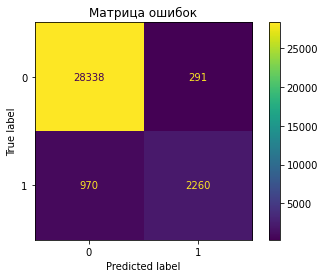

In [47]:
# Выведем матрицу ошибок
cm = confusion_matrix(target_test, predictions_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)                            
disp.plot()
plt.title('Матрица ошибок')
plt.show();


## 3 Выводы

В ходе исследования были выполнены следующие шаги:
- Из датафрейма удалены сведения, не учавствующие в обучении моделей;
- тектсты очищены от знаков препинания, лишних символов и пробелов, лемматизированы;
- лемматизация текста заняла около 20 минут;
- данные были разделены на обучающую и тестовую выборки в соотношении 80  на 20, выделен целевой признак 'toxic';
- в данных имелся дисбаланс классов - токсичных комментариев ожидаемо сильно меньше, чем не токсичных;
- были обучены модели логистической регрессии, дерева решений и случайного леса;
- подбор гиперпараметров осуществлялся с помощью кросс-валидации, метрикой качества являлась f-мера;
- в результате исследования для дальнейшего внедрения рекомендуется модель логистической регрессии, как модель с самым высоким значением метрики;
- данная модель также хороша высокой скоростью работы и легкой интерпретируемостью;
- выбраная модель проверена на тестовой выборке, результаты ее предсказаний отображены в матрице ошибок.